In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from wordcloud import WordCloud
import networkx as nx
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

In [121]:
games = pd.read_csv("metacritic_games_data.csv")
games.head()

,title,release_date,rating,description,metascore,platforms,platform_scores
0,The Legend of Zelda: Ocarina of Time,1998-11-23,E,"As a young boy, Link is tricked by Ganondorf, ...",99,['nintendo-64'],['99']
1,SoulCalibur,1999-09-08,T,"This is a tale of souls and swords, transcendi...",98,"['mobile', 'dreamcast', 'xbox-360']","['73', '98', '79']"
2,Grand Theft Auto IV,2008-04-29,M,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,"['pc', 'ps3', 'xbox-360']","['90', '98', '98']"
3,Super Mario Galaxy,2007-11-12,E,[Metacritic's 2007 Wii Game of the Year] The u...,97,['wii'],['97']
4,Super Mario Galaxy 2,2010-05-23,E,"Super Mario Galaxy 2, the sequel to the galaxy...",97,['wii'],['97']


In [122]:
games['release_date'] = pd.to_datetime(games['release_date'])
games['metascore'] = games['metascore'].replace('Metascore not available', -1).astype(int)
games['metascore'] = games['metascore'].astype(int)
games['description'] = games['description'].astype(str)
games['rating'] = games['rating'].str.replace('K', 'E')

In [123]:
games_by_year = games
games_by_year['year'] = games_by_year['release_date'].dt.year
games_by_year['month'] = games_by_year['release_date'].dt.month
games_by_year['day'] = games_by_year['release_date'].dt.day
games_by_year.head()

,title,release_date,rating,description,metascore,platforms,platform_scores,year,month,day
0,The Legend of Zelda: Ocarina of Time,1998-11-23,E,"As a young boy, Link is tricked by Ganondorf, ...",99,['nintendo-64'],['99'],1998,11,23
1,SoulCalibur,1999-09-08,T,"This is a tale of souls and swords, transcendi...",98,"['mobile', 'dreamcast', 'xbox-360']","['73', '98', '79']",1999,9,8
2,Grand Theft Auto IV,2008-04-29,M,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,"['pc', 'ps3', 'xbox-360']","['90', '98', '98']",2008,4,29
3,Super Mario Galaxy,2007-11-12,E,[Metacritic's 2007 Wii Game of the Year] The u...,97,['wii'],['97'],2007,11,12
4,Super Mario Galaxy 2,2010-05-23,E,"Super Mario Galaxy 2, the sequel to the galaxy...",97,['wii'],['97'],2010,5,23


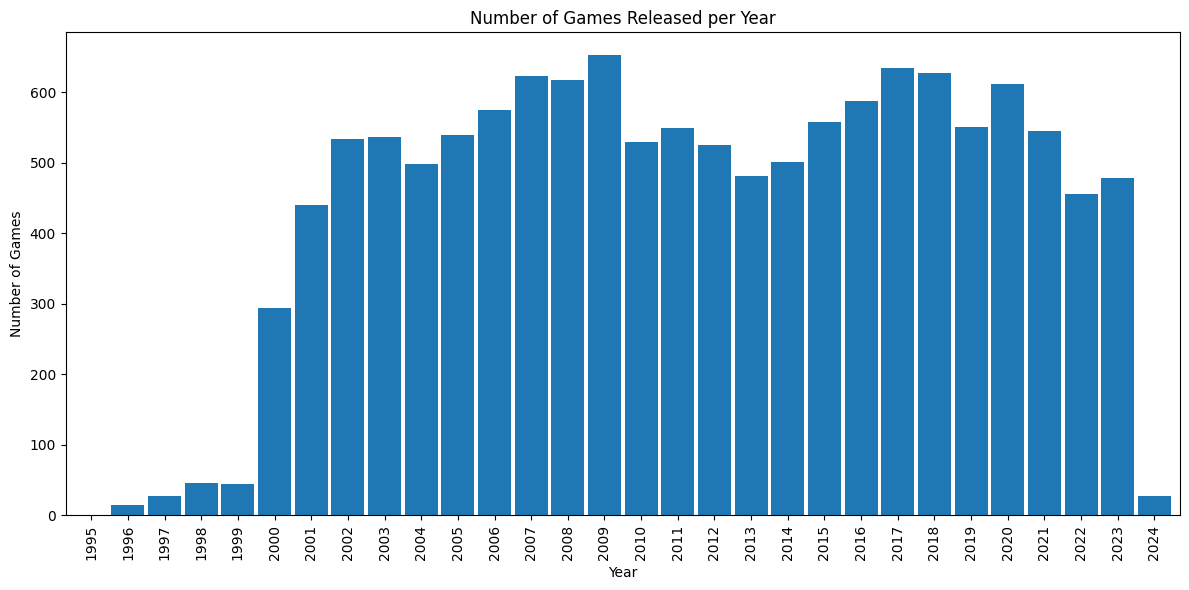

In [124]:
games_per_year = games_by_year.groupby('year')['title'].count()

# Plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size for better readability
games_per_year.plot(kind='bar', width=0.9)  # Use a bar chart for distinct years
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')

# Set x-ticks to ensure every year is listed and readable
plt.xticks(rotation=90)  # Rotate the x-axis labels to vertical for better readability

plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()

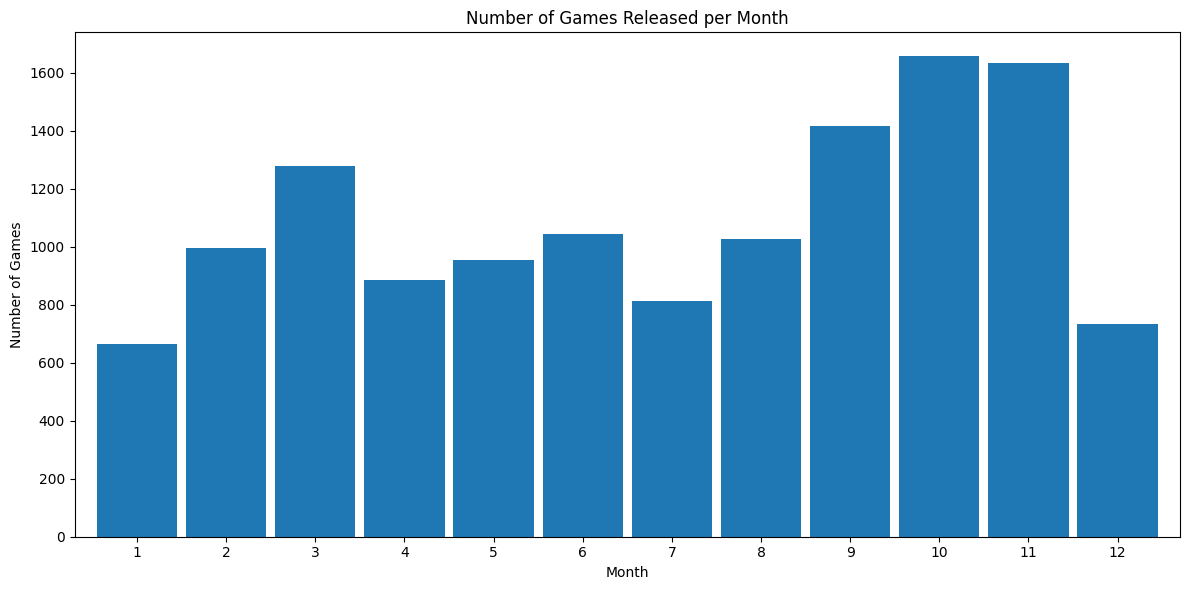

In [125]:
games_per_month = games_by_year.groupby('month')['title'].count()

# Plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size for better readability
games_per_month.plot(kind='bar', width=0.9)  # Use a bar chart for distinct years
plt.title('Number of Games Released per Month')
plt.xlabel('Month')
plt.ylabel('Number of Games')
plt.xticks(rotation=0)
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()

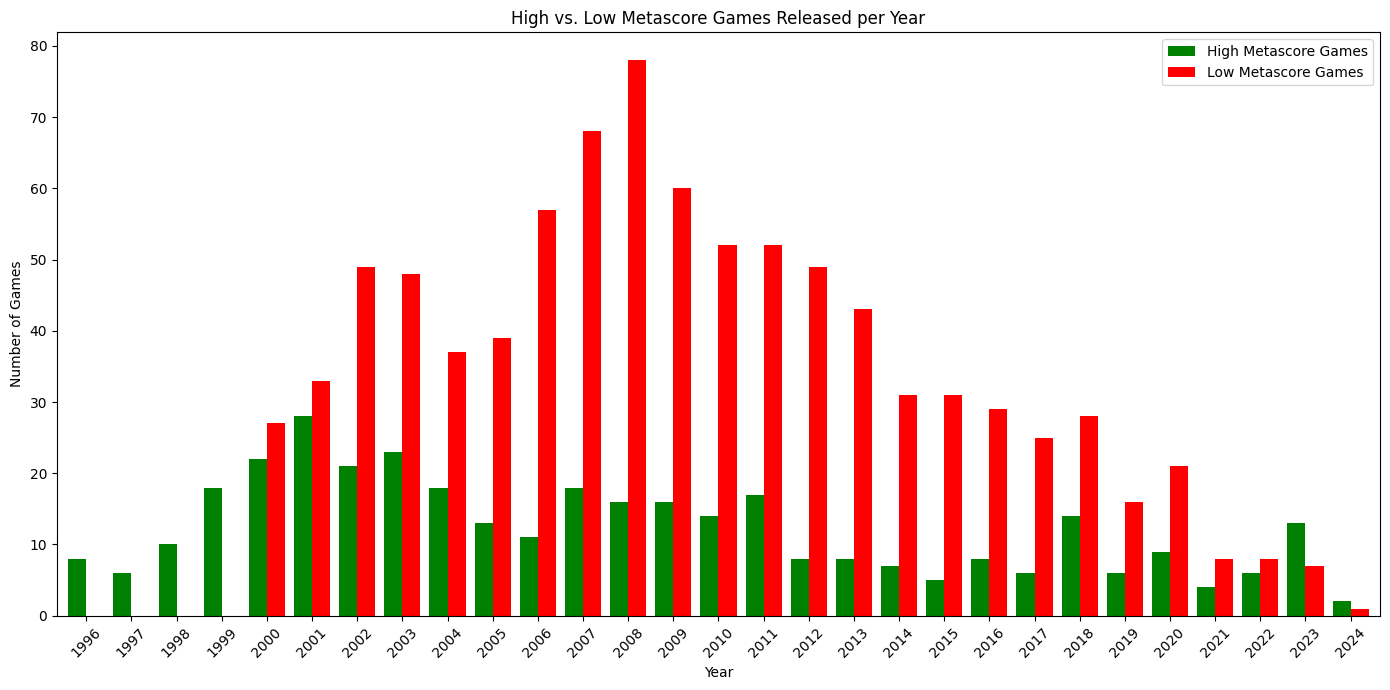

In [126]:
# Filter games into high and low metascore groups
high_metascore_games = games_by_year[games_by_year['metascore'] >= 90]
low_metascore_games = games_by_year[games_by_year['metascore'] < 50]

# Group by year and count the number of games for each group
high_metascore_count = high_metascore_games.groupby('year').size()
low_metascore_count = low_metascore_games.groupby('year').size()

# Combine into a single DataFrame
counts_df = pd.DataFrame({'High Metascore Games': high_metascore_count,
                          'Low Metascore Games': low_metascore_count})

# Fill NaN values with 0 since a NaN would mean no games of that type were released in that year
counts_df = counts_df.fillna(0)

# Plotting
# Ensure the index is of type string for better x-axis labeling
counts_df.index = counts_df.index.map(str)

# Plot
counts_df.plot(kind='bar', figsize=(14, 7), width=0.8, color=['green', 'red'])
plt.title('High vs. Low Metascore Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


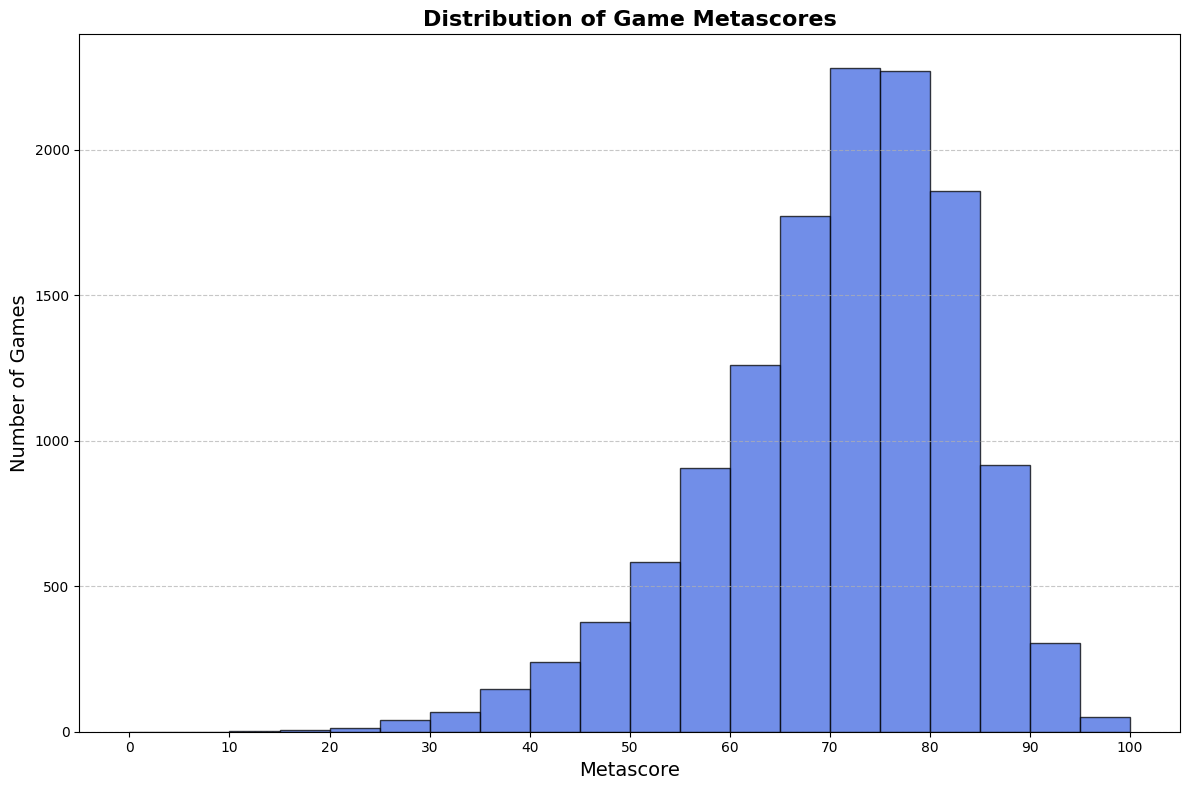

In [127]:
# Determine the range of metascores to set appropriate bins
min_metascore = games_by_year['metascore'].min() + 1 # Avoiding "Metascore not available" that is under -1
max_metascore = games_by_year['metascore'].max()

# Calculate the number of bins to use - aiming for a bin width of around 5 score units for clarity
bins = np.arange(start=min_metascore, stop=max_metascore + 5, step=5)

plt.figure(figsize=(12, 8))  # Adjusting figure size for better visualization

# Plotting the histogram with the new bins
plt.hist(games_by_year['metascore'], bins=bins, edgecolor='k', alpha=0.75, color='royalblue')

plt.title('Distribution of Game Metascores', fontsize=16, fontweight='bold')
plt.xlabel('Metascore', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)

# Removing x-ticks rotation and setting a smaller step for readability
plt.xticks(np.arange(min_metascore, max_metascore + 10, 10))

# Adding grid lines for better readability of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust the layout
plt.show()


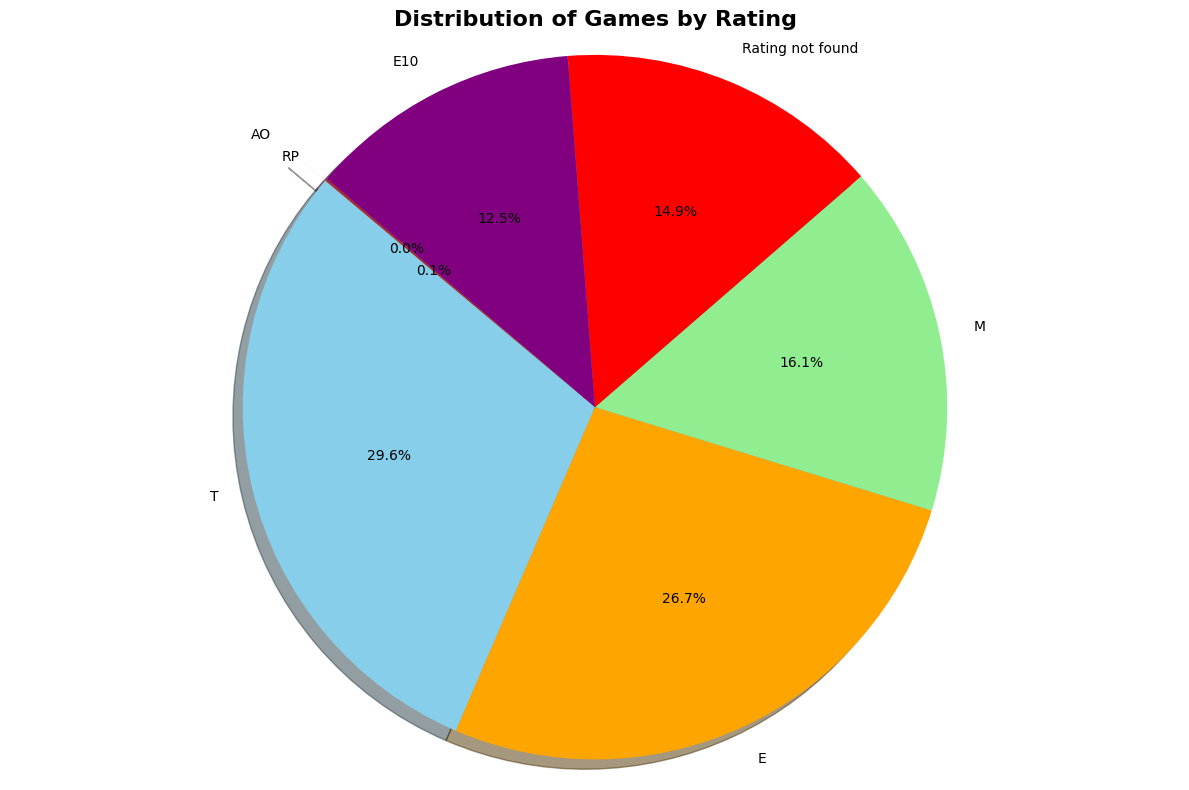

In [128]:
# Count the number of games by rating
rating_counts = games_by_year['rating'].value_counts()

# Define colors for each rating to make the chart more visually distinct
colors = ['skyblue', 'orange', 'lightgreen', 'red', 'purple', 'brown', 'pink', 'grey', 'yellow', 'black']
# Ensure there are enough colors for each rating
colors = colors[:len(rating_counts)]

# Explode the smallest segment slightly
explode = [0.1 if i == rating_counts.idxmin() else 0 for i in rating_counts.index]

# Increase figure size
plt.figure(figsize=(12, 8))

# Plot pie chart with adjusted autopct fontsize and explode for smallest segment
plt.pie(rating_counts, labels=rating_counts.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=colors, explode=explode, shadow=True)

plt.title('Distribution of Games by Rating', fontsize=16, fontweight='bold')

# Draw a circle at the center of pie to make it look like a donut chart
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

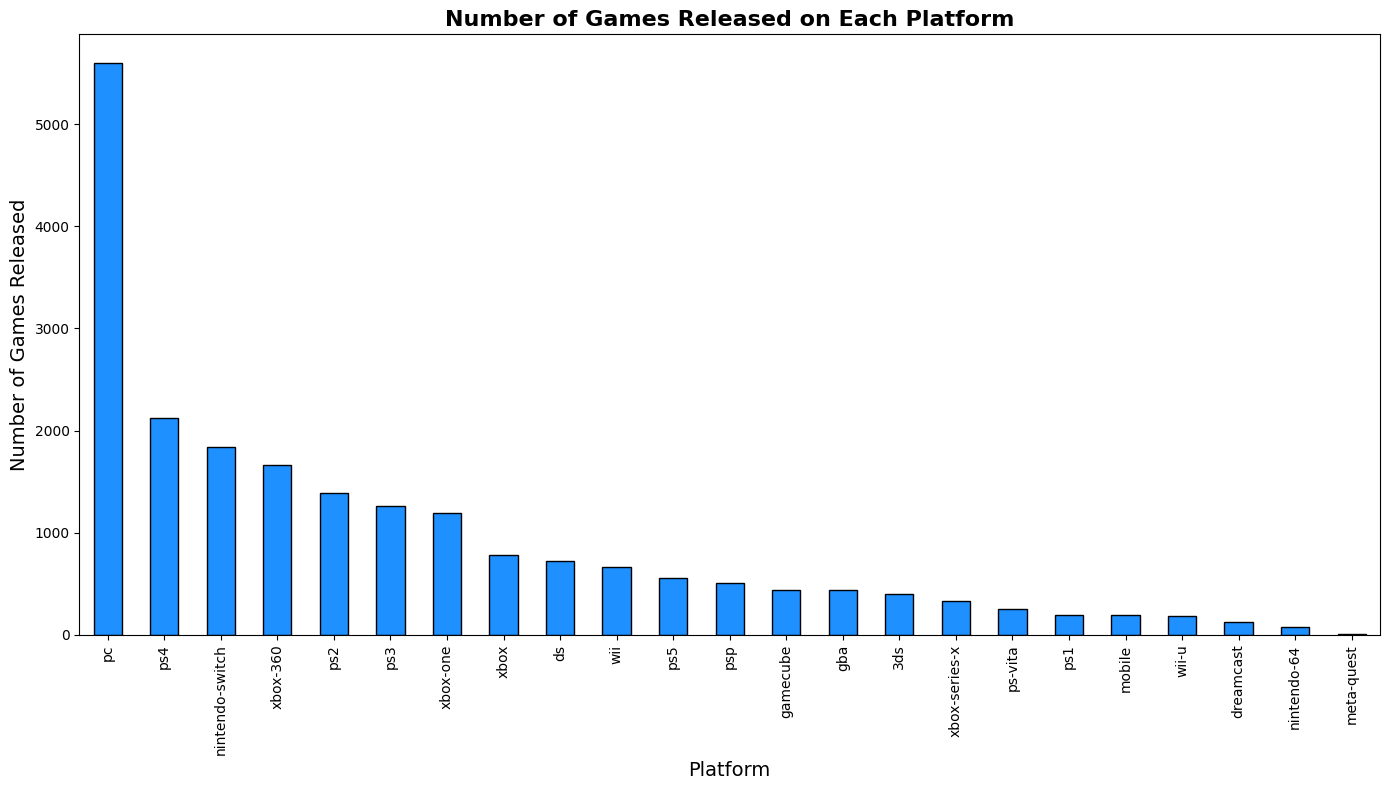

In [129]:
# Step 1: Evaluate the string representation of lists into actual lists
games_by_year['platforms'] = games_by_year['platforms'].apply(ast.literal_eval)
games_by_year['platform_scores'] = games_by_year['platform_scores'].apply(ast.literal_eval)

# Step 2: Pair each platform with its corresponding score
# Create a new dataframe where each pair (platform and score) is a separate row
rows = []
for i, row in games_by_year.iterrows():
    for platform, score in zip(row['platforms'], row['platform_scores']):
        rows.append({'title': row['title'], 'platform': platform, 'score': score})

paired_df = pd.DataFrame(rows)

# Step 3: Pivot this dataframe to widen it
# This will create a new dataframe with each platform as a column
# The first argument in pivot_table is the new column names
# The second argument is the column to use to fill values in the new columns
# The third argument aggregates the scores, in case there are multiple scores per platform for different games
platform_scores_pivot = paired_df.pivot_table(index='title', columns='platform', values='score', aggfunc='first')

# Now, you can count the number of game releases per platform
platform_counts = platform_scores_pivot.count().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(14, 8))  # Set a larger figure size to accommodate many platforms
platform_counts.plot(kind='bar', color='dodgerblue', edgecolor='black')

plt.title('Number of Games Released on Each Platform', fontsize=16, fontweight='bold')
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Number of Games Released', fontsize=14)
plt.xticks(rotation=90)  # Rotate the platform names for better readability

plt.tight_layout()  # Adjust the layout to fit everything
plt.show()


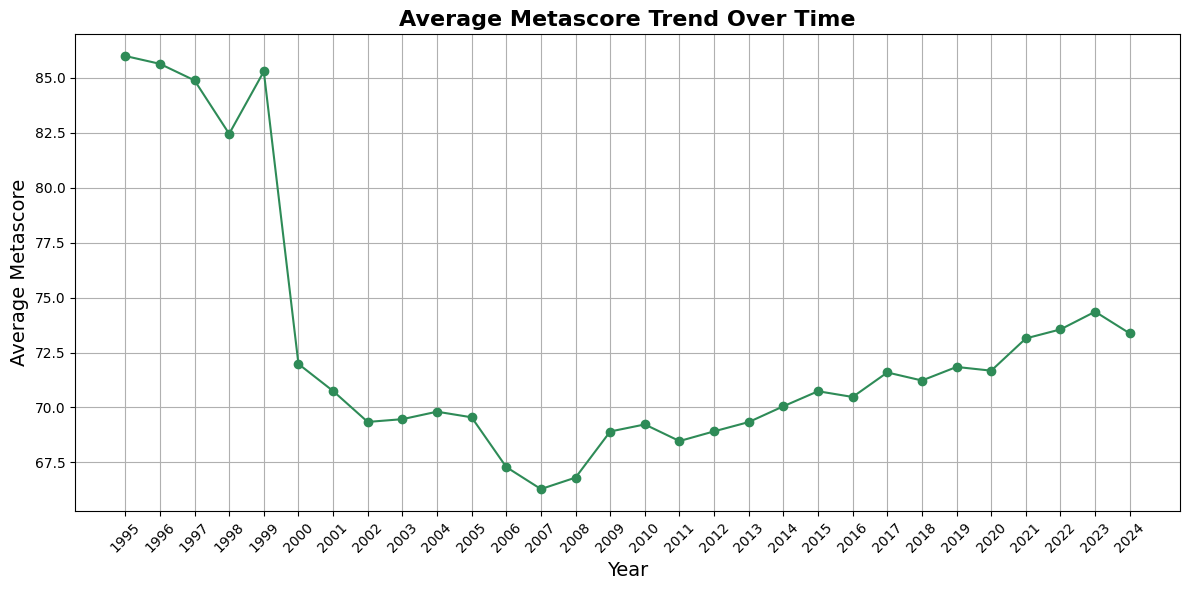

In [130]:
# Group by the year and calculate the average metascore
average_metascore_per_year = games_by_year.groupby('year')['metascore'].mean()

# Plotting
plt.figure(figsize=(12, 6))
average_metascore_per_year.plot(kind='line', color='seagreen', marker='o')

plt.title('Average Metascore Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Metascore', fontsize=14)
plt.grid(True)
plt.xticks(range(min(games_by_year['year']), max(games_by_year['year'])+1, 1), rotation=45)
plt.tight_layout()

plt.show()

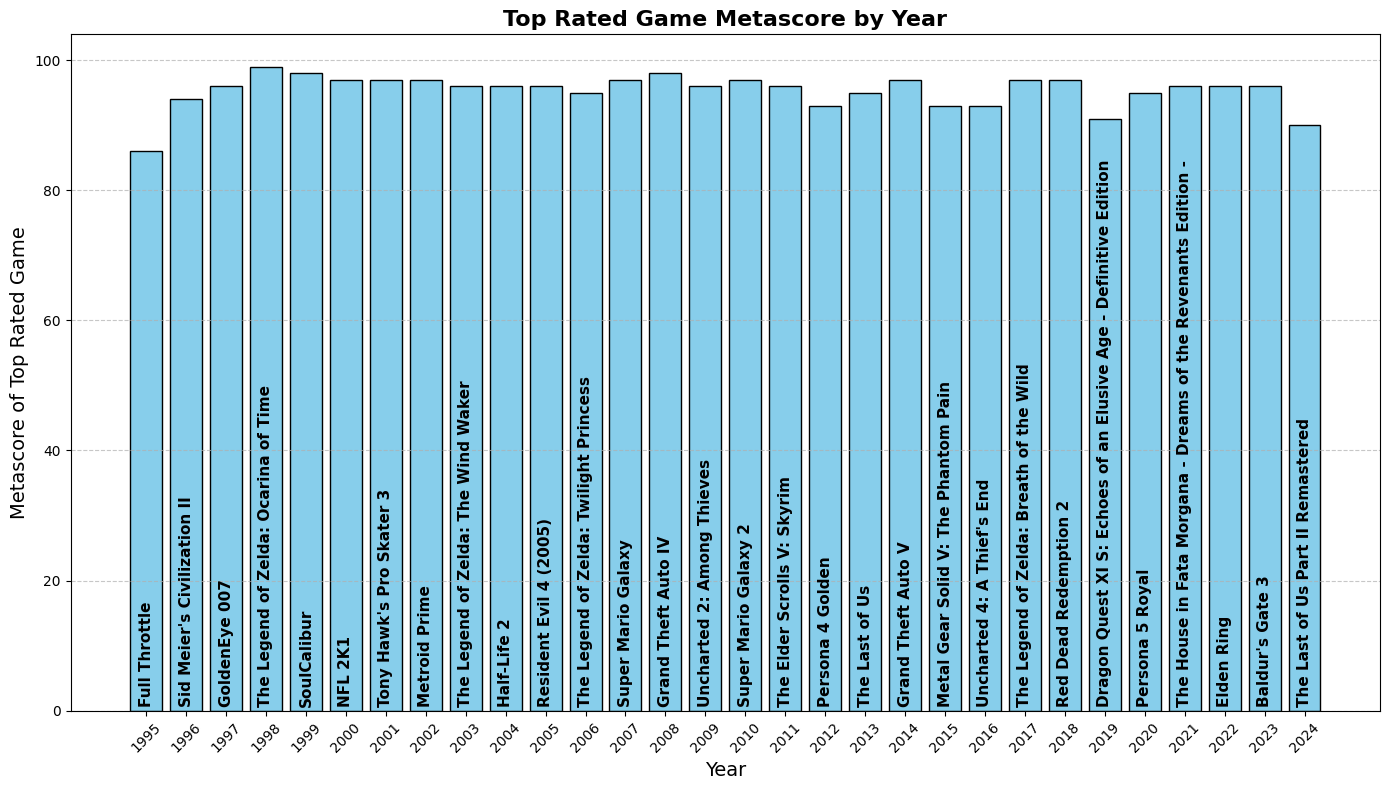

In [131]:
# Group by year and find the index of the game with the highest metascore each year
top_rated_idx = games_by_year.groupby('year')['metascore'].idxmax()

# Select the top rated games using the indices found above
top_rated_games_each_year = games_by_year.loc[top_rated_idx]

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(top_rated_games_each_year['year'], top_rated_games_each_year['metascore'], color='skyblue', edgecolor='black')

plt.title('Top Rated Game Metascore by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metascore of Top Rated Game', fontsize=14)

# Annotate each bar with the name of the top-rated game
for bar, game_title in zip(bars, top_rated_games_each_year['title']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 0.5, game_title, ha='center', va='bottom', rotation=90, fontsize=11, color='black', weight='bold')

plt.xticks(top_rated_games_each_year['year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

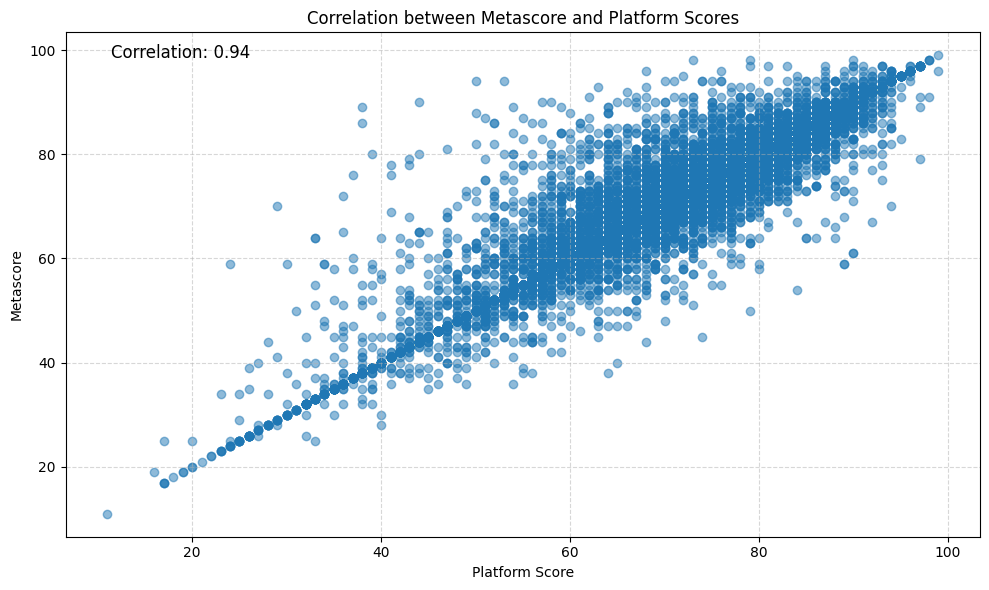

In [132]:
# Function to pair platforms and platform_scores
def pair_platform_scores(row):
    return list(zip(row['platforms'], row['platform_scores']))

# Apply the function to each row
games_by_year['platform_score_pairs'] = games_by_year.apply(pair_platform_scores, axis=1)

# Explode the paired platform_score_pairs to separate rows
games_exploded = games_by_year.explode('platform_score_pairs')

# Split the pairs into two separate columns
games_exploded[['platform', 'platform_score']] = pd.DataFrame(games_exploded['platform_score_pairs'].tolist(), index=games_exploded.index)

# Filter out rows with non-numeric platform scores or missing metascores
games_exploded = games_exploded[pd.to_numeric(games_exploded['platform_score'], errors='coerce').notnull()]
games_exploded = games_exploded[games_exploded['metascore'] > 0]

# Convert platform scores to numeric values
games_exploded['platform_score'] = pd.to_numeric(games_exploded['platform_score'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(games_exploded['platform_score'], games_exploded['metascore'], alpha=0.5)

# Labeling the axes
plt.title('Correlation between Metascore and Platform Scores')
plt.xlabel('Platform Score')
plt.ylabel('Metascore')

# Show the correlation coefficient
corr_coef = np.corrcoef(games_exploded['platform_score'], games_exploded['metascore'])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr_coef:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

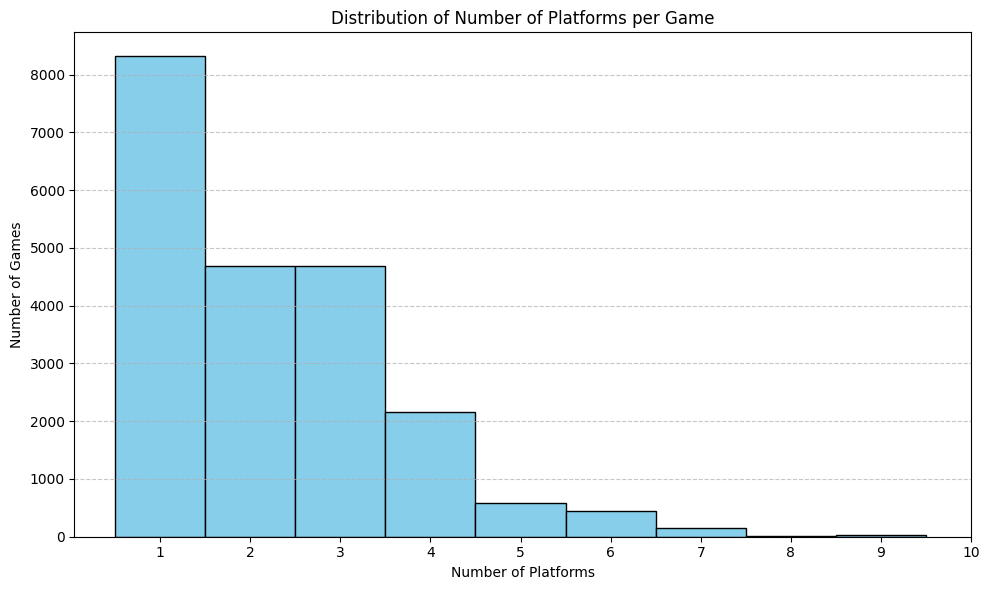

In [133]:
# Count the number of platforms each game is released on
games_exploded['game_platform_count'] = games_exploded.groupby('title')['platform'].transform('count')

# Filter to include only games released on more than one platform
multi_platform_games = games_exploded[games_exploded['game_platform_count'] >= 1]

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(multi_platform_games['game_platform_count'], bins=range(1, multi_platform_games['game_platform_count'].max()+1), align='left', color='skyblue', edgecolor='black')

plt.title('Distribution of Number of Platforms per Game')
plt.xlabel('Number of Platforms')
plt.ylabel('Number of Games')
plt.xticks(range(1, multi_platform_games['game_platform_count'].max()+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


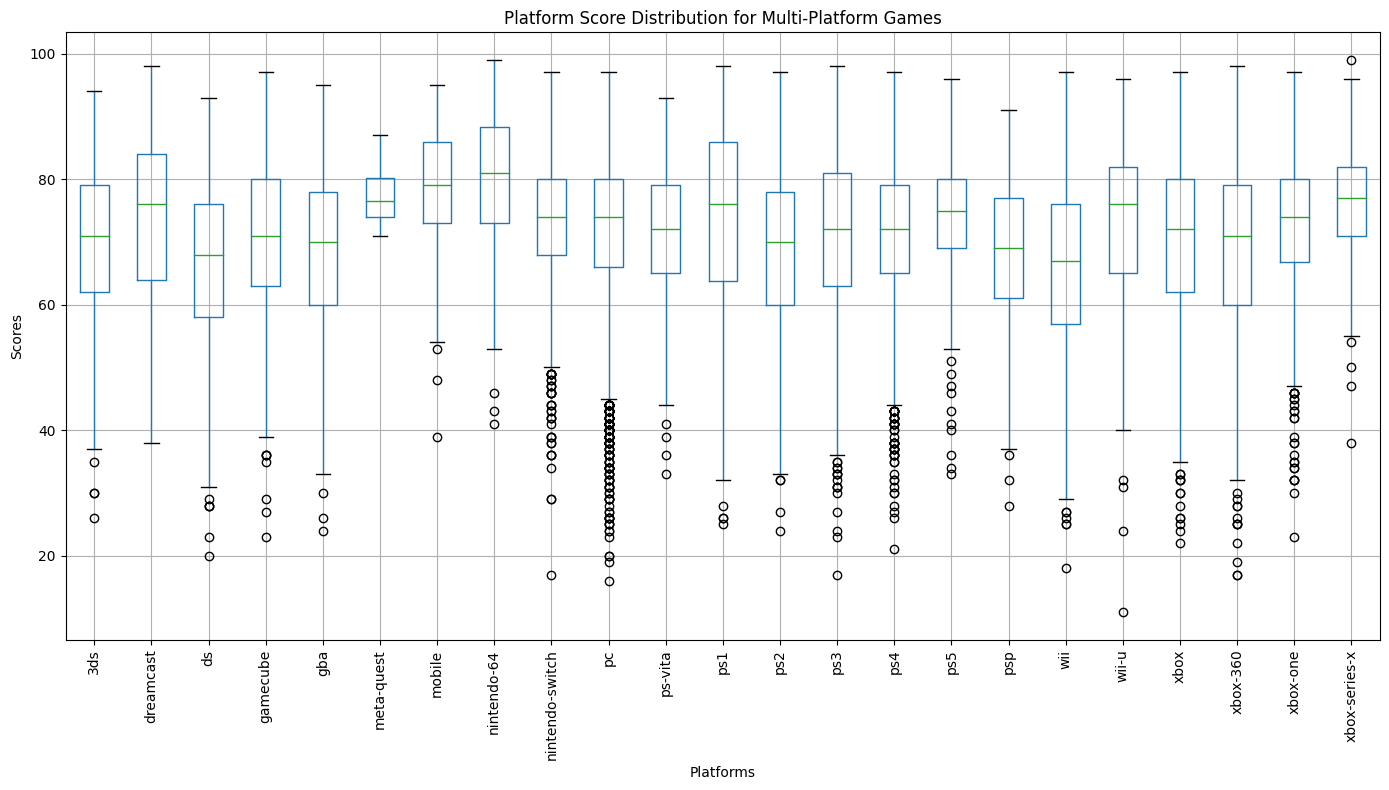

In [134]:
# Use pivot_table instead of pivot to handle duplicate entries by calculating the mean score
pivot_scores = multi_platform_games.pivot_table(index='title', columns='platform', values='platform_score', aggfunc='mean')

# Plot a box plot
plt.figure(figsize=(14, 8))
pivot_scores.boxplot(rot=90, grid=True)

plt.title('Platform Score Distribution for Multi-Platform Games')
plt.ylabel('Scores')
plt.xlabel('Platforms')
plt.tight_layout()

plt.show()


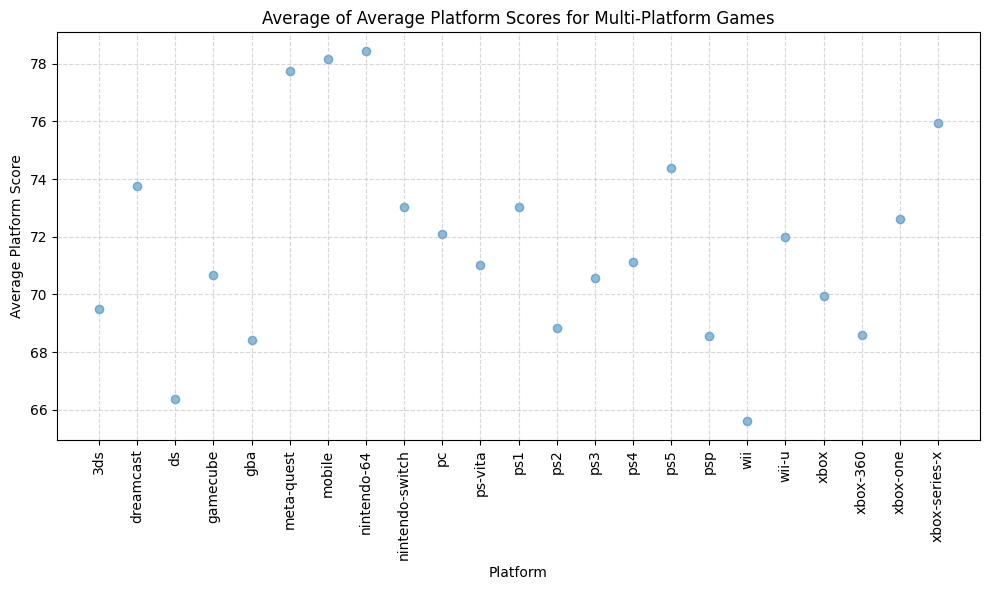

In [135]:
# Group by title and platform to calculate the average score
platform_scores_avg = multi_platform_games.groupby(['title', 'platform'])['platform_score'].mean().reset_index()

# Now group by platform to get the average of the average scores for each platform
platform_scores_summary = platform_scores_avg.groupby('platform')['platform_score'].mean()

# Create a scatter plot using the summary information
plt.figure(figsize=(10, 6))
plt.scatter(platform_scores_summary.index, platform_scores_summary.values, alpha=0.5)

# Labeling the axes
plt.title('Average of Average Platform Scores for Multi-Platform Games')
plt.xlabel('Platform')
plt.ylabel('Average Platform Score')

plt.xticks(rotation=90)  # Rotate the platform names for better readability
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

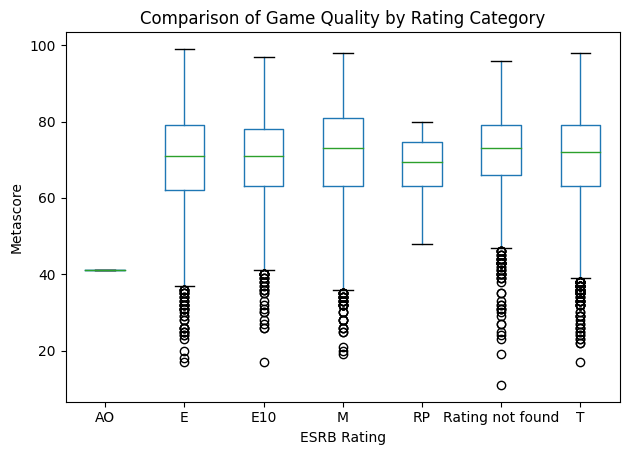

In [136]:
# Filter out invalid metascores (e.g., where metascore is -1 or 'Metascore not available')
valid_scores = games_by_year[games_by_year['metascore'] > 0]

# Create box plots of metascores grouped by game rating
plt.figure(figsize=(10, 6))
valid_scores.boxplot(column='metascore', by='rating', grid=False)

plt.title('Comparison of Game Quality by Rating Category')
plt.suptitle('')  # Suppress the default title to clean up the plot
plt.xlabel('ESRB Rating')
plt.ylabel('Metascore')

plt.tight_layout()
plt.show()

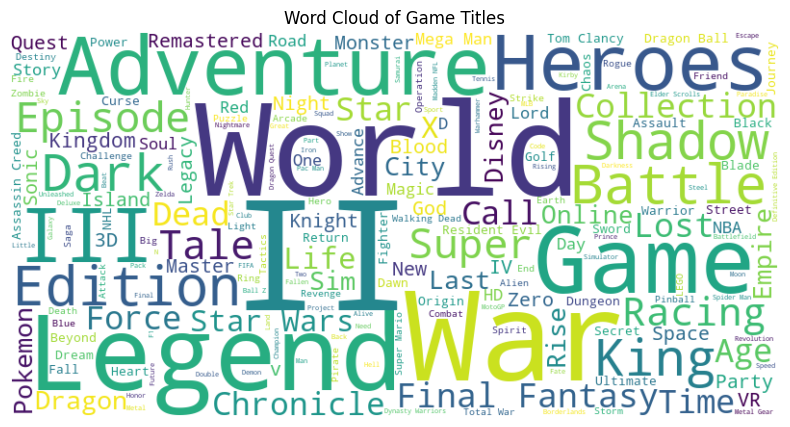

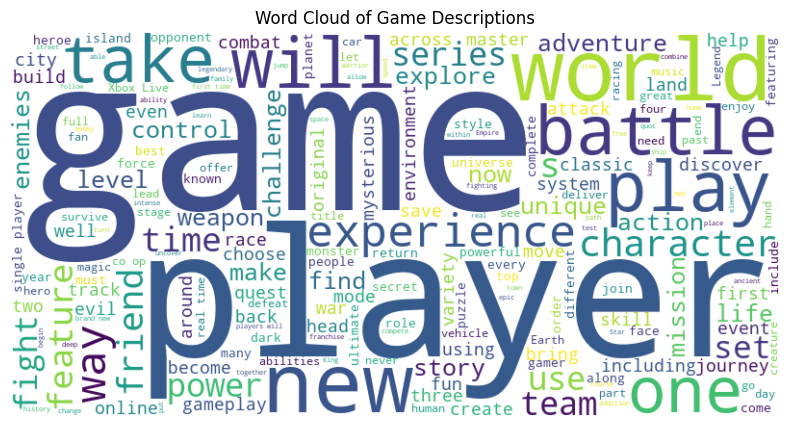

In [137]:
# Combine all game titles into a single string
all_titles = ' '.join(games_by_year['title'].tolist())

# Combine all game descriptions into a single string
all_descriptions = ' '.join(games_by_year['description'].tolist())

# Generate a word cloud for titles
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Generate a word cloud for descriptions
wordcloud_descriptions = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Display the word cloud for titles
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Game Titles')
plt.show()

# Display the word cloud for descriptions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descriptions, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Game Descriptions')
plt.show()

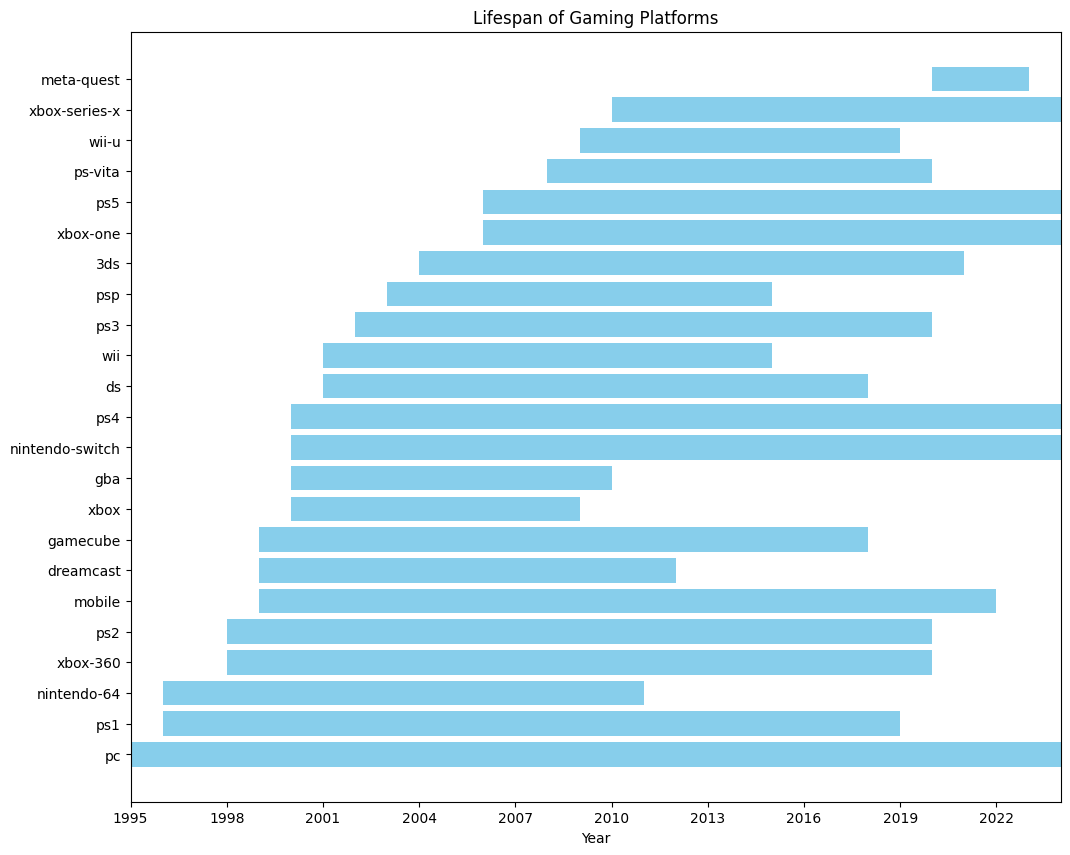

In [139]:
# Explode the 'platforms' column into separate rows
platforms_lifespan = games_by_year.explode('platforms')

# Group by 'platforms' and find the earliest and latest release dates
platform_lifespan_data = platforms_lifespan.groupby('platforms')['release_date'].agg(['min', 'max'])

# Calculate the lifespan as the number of years between the first and last game release
platform_lifespan_data['lifespan'] = platform_lifespan_data['max'].dt.year - platform_lifespan_data['min'].dt.year

# Sort the platforms by the start date
platform_lifespan_data = platform_lifespan_data.sort_values('min')

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Each bar represents the lifespan of a platform
ax.barh(platform_lifespan_data.index, 
        platform_lifespan_data['lifespan'],  # Lifespan in years
        left=platform_lifespan_data['min'].dt.year,  # Start year
        color='skyblue')

ax.set_xlabel('Year')
ax.set_title('Lifespan of Gaming Platforms')

# Set the x-axis to display years with an integer locator
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Optionally, set the x-axis limits to the earliest and latest years in the dataset
ax.set_xlim([platform_lifespan_data['min'].min().year, platform_lifespan_data['max'].max().year])

plt.show()


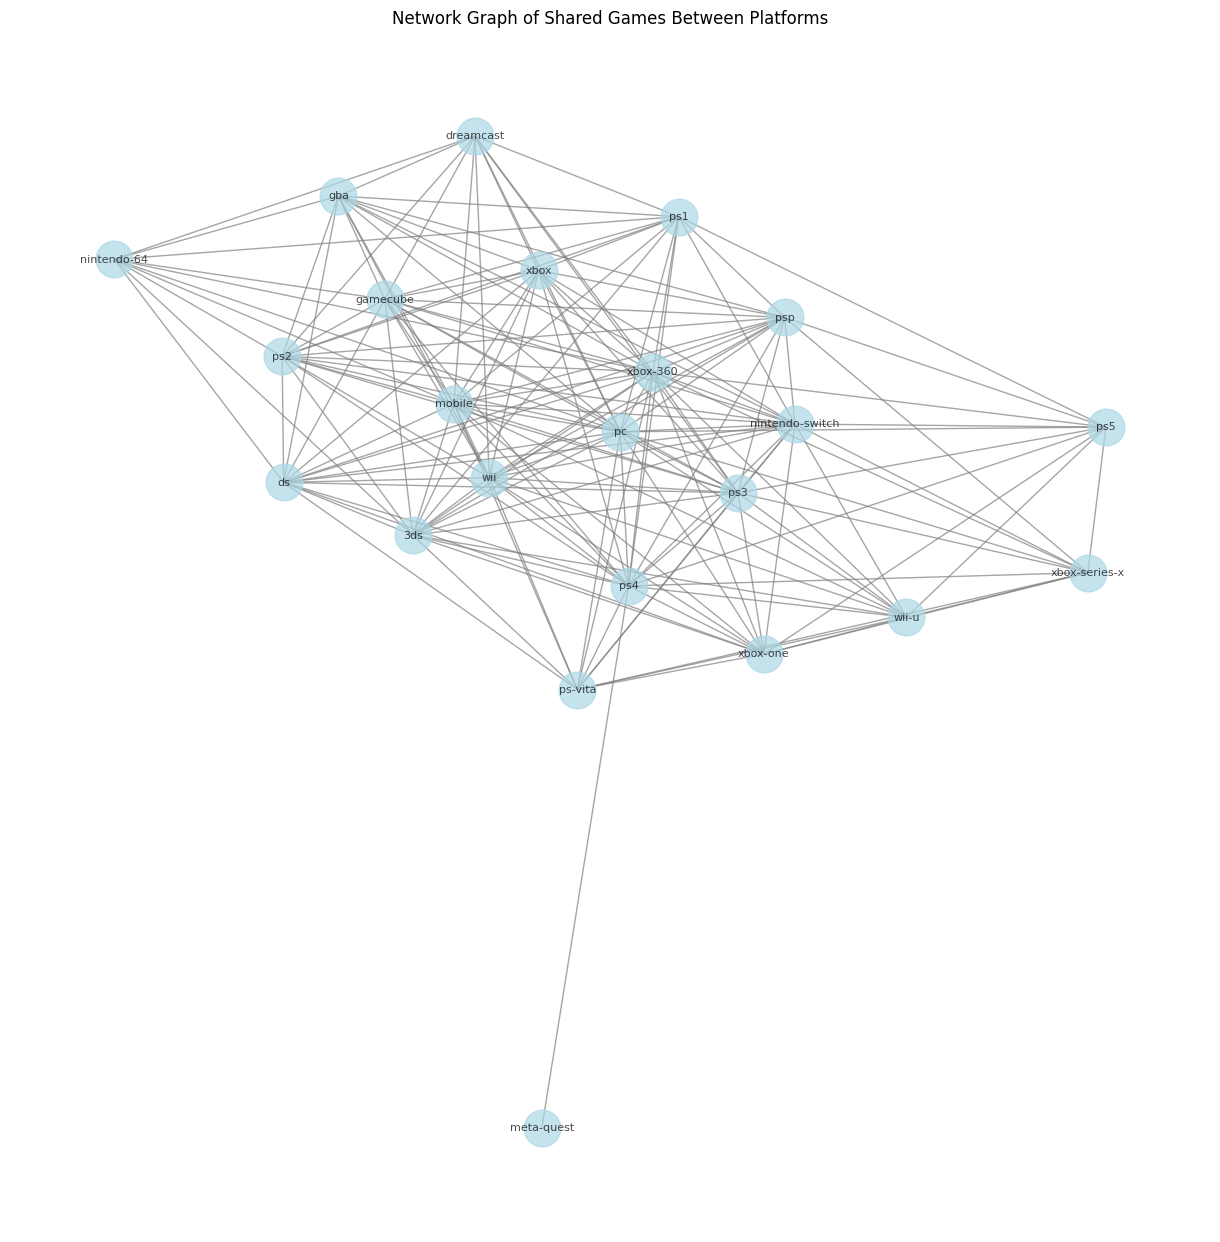

In [143]:
# Generate a list of all platform combinations for each game
platform_combinations = games_by_year['platforms'].apply(lambda x: list(itertools.combinations(x, 2)))

# Flatten the list of platform combinations
flat_platform_combinations = list(itertools.chain.from_iterable(platform_combinations))

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for combination in flat_platform_combinations:
    if combination:  # Check if the combination is not empty
        G.add_edge(*combination)  # Unpack the tuple and add an edge

# Draw the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, iterations=50)  # Layout for the nodes

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)


plt.title('Network Graph of Shared Games Between Platforms')
plt.axis('off')  # Hide the axis
plt.show()

In [154]:
# Convert platform_scores lists to numeric and handle non-numeric entries
games_by_year['platform_scores'] = games_by_year['platform_scores'].apply(
    lambda scores: [pd.to_numeric(score, errors='coerce') for score in scores]
)

# Calculate the average platform score while ignoring NaNs
games_by_year['avg_platform_score'] = games_by_year['platform_scores'].apply(
    lambda scores: np.nanmean([score for score in scores if not np.isnan(score)])
)

# Now we have 'metascore' and 'avg_platform_score', let's check for NaN values
print("NaN values in metascore:", games_by_year['metascore'].isna().sum())
print("NaN values in avg_platform_score:", games_by_year['avg_platform_score'].isna().sum())

# Drop NaN values for clustering
games_by_year.dropna(subset=['metascore', 'avg_platform_score'], inplace=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(games_by_year[['metascore', 'avg_platform_score']])

# Perform hierarchical clustering
Z = linkage(scaled_features, method='ward')

# Create a flat cluster assignment based on a distance threshold
distance_threshold = 100  # Example threshold, adjust based on your data
clusters = fcluster(Z, t=distance_threshold, criterion='distance')
games_by_year['cluster'] = clusters

# Create a label mapping for each cluster
cluster_labels = games_by_year.groupby('cluster')['rating'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'N/A')
label_mapping = {row.name: f"Cluster {row.name} - {row['rating']}" for row in cluster_labels.reset_index()}

# Generate labels for each point in the dendrogram
dendrogram_labels = [label_mapping.get(cluster, 'N/A') for cluster in clusters]

# Generate the dendrogram with appropriate labels
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=dendrogram_labels, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Label')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

NaN values in metascore: 0
NaN values in avg_platform_score: 0


AttributeError: 'str' object has no attribute 'name'